# Imports

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

from utils.data import init_gamma, init_beta
from utils.model import Model
from utils.client import Client 
from utils.splines import bspline_design_matrix

2025-08-01 09:16:05.682764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configs

In [2]:
# NOTE: Reducing EPS will improve accuracy. Parameter accuracy is a function of EPS 
EPS = 1e-5
N_ITER_GLOBAL = 10000

N_SAMPLES = 500

np.random.seed(42)
SEEDS = np.random.choice(range(10000), size=5)
print(SEEDS)

rho = 1

[7270  860 5390 5191 5734]


# Data

In [3]:
event_col = "event"
duration_col = "duration"

In [4]:
from sklearn.datasets import make_classification


def make_data(n_samples, seed):

    # Feature matrix and event time 
    X, y = make_classification(
        n_samples=N_SAMPLES, n_features=5, n_informative=2, n_redundant=2, n_repeated=0, 
        n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, 
        hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=seed
    )

    rnd = np.random.RandomState(seed=seed)
    
    # Simulate event times
    # Class 1 -> shorter survival time, Class 0 -> longer
    baseline_time = rnd.exponential(scale=10, size=y.shape[0])
    survival_time = baseline_time * (0.5 + y)  # Class 1 has shorter survival times
    
    # Simulate random censoring
    censoring_time = rnd.exponential(scale=15, size=y.shape[0])
    duration = np.minimum(survival_time, censoring_time)
    event = survival_time <= censoring_time
    
    # Create DataFrame for clarity
    data = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
    data[duration_col] = duration
    data[event_col] = event.astype(int)

    return data, X, event, duration


data, X, event, duration = make_data(N_SAMPLES, SEEDS[0])
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,duration,event
0,-0.283269,-1.503986,0.584319,1.110368,0.752608,7.851225,1
1,0.430450,-0.982862,-0.078302,0.474867,0.481233,5.382143,0
2,-1.700872,-1.174093,1.562304,-3.204284,0.613009,1.009546,0
3,-0.451474,0.769189,0.146950,-0.108875,-0.374640,1.148273,1
4,0.278403,-0.567891,-0.067439,-1.028853,0.277542,4.765891,1


In [5]:
from sksurv.util import Surv
# Create structured arrays
y = Surv.from_arrays(event=event, time=duration)

# Pre-processing 

In [6]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X_sc = feature_scaling(X)

In [7]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration, event, n_knots=5)
min(knots), max(knots)

(-3.317493653263726, 3.6080090924908443)

In [8]:
sum(event) / len(event), X.shape

(0.624, (500, 5))

# Fit reference model 

Converged after 3398 iterations


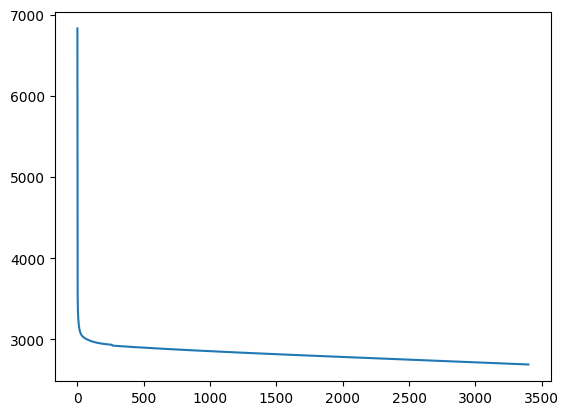

In [9]:
beta = init_beta(X_sc, y)
gamma = np.ones((1, 7))

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.001, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X_sc, y, tol=EPS)

plt.figure()
plt.plot(ref_model.losses)

In [10]:
#np.save("../data/price-of-federation/rossi_gradients_loss_ref.npy", ref_model.losses)

In [11]:
#np.save("../data/price-of-federation/rossi_gradients_beta_global_ref.npy", ref_model.beta)
#ref_model.beta

In [12]:
#np.save("../data/price-of-federation/rossi_gradients_gamma_global_ref.npy", ref_model.gamma)
#ref_model.gamma

# Number of clients 

In [13]:
def has_converged(params, params_other):
    return np.linalg.norm(params_other - params) <= EPS 

In [14]:
# - Made synthetic data generator 
# - Critical to have IID data per client to study optimization process 
# - However, IID data will give only small variance to gradients. Using ADAM, a consequence is 
#   effectively a larger learning rate. Must scale the learning rate to account for this effect 
for seed in SEEDS:
    print("*" * 20)
    print("SEED:", seed)
    print("*" * 20)
    for N_SPLITS in [1, 2, 4, 6, 8, 10]:
        
        data_idx = np.arange(data.shape[0])
        np.random.seed(seed)
        np.random.shuffle(data_idx)
        DATA_SPLIT_IDX = np.array_split(data_idx, N_SPLITS)

        
        participants = []
        for idx in range(N_SPLITS):
            client = Client(data.iloc[DATA_SPLIT_IDX[idx]], n_knots=5, n_epochs=None, event_col=event_col, duration_col=duration_col, rho=rho)
            client.preprocess_data(train_test_split=False)
            client.init_model(local_knots=False, knots=knots, learning_rate=0.001)
            participants.append(client)
        
        beta_global = beta.copy()
        gamma_global = gamma.copy()
        beta_global_tf = tf.Variable(beta_global, dtype=tf.float32)
        gamma_global_tf = tf.Variable(gamma_global, dtype=tf.float32)
        beta_global_prev = np.zeros_like(beta_global)
        gamma_global_prev = np.zeros_like(gamma_global)

        
        optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

        
        losses = []
        for i in range(N_ITER_GLOBAL):
            losses_i = []
            gradients_beta, gradients_gamma = 0, 0 
            for client in participants:
                grad_beta, grad_gamma = client.gradients_adjusted(beta_global_tf, gamma_global_tf, q_scale=100)
                gradients_beta += grad_beta 
                gradients_gamma += grad_gamma 
                losses_i.append(client.model_loss())
            
            losses.append(np.mean(losses_i))
            optimiser.apply_gradients(zip([gradients_beta, gradients_gamma], [beta_global_tf, gamma_global_tf]))
            
            beta_global = beta_global_tf.numpy()
            gamma_global = gamma_global_tf.numpy()
            
            if has_converged(beta_global, beta_global_prev) and has_converged(gamma_global, gamma_global_prev):
                print(f"Converged after {i} iterations")
                break 
        
            if i % (N_ITER_GLOBAL / 10) == 0:
                change_beta = np.linalg.norm(beta_global - beta_global_prev) 
                change_gamma = np.linalg.norm(gamma_global - gamma_global_prev)
                print(f"Iter {i}: {change_beta}; {change_gamma}")
        
            beta_global_prev = beta_global
            gamma_global_prev = gamma_global
        
        print("-" * 20)
        print("Diff beta:", np.linalg.norm(beta_global - ref_model.beta))
        print("Diff gamma:", np.linalg.norm(gamma_global - ref_model.gamma))
        print()
        print()
        
        version = f"seed_{seed}_clients_{N_SPLITS}"
        
        np.save(f"../data/results-price-of-federation-synth-exp-bias-correction/loss_{version}.npy", losses)
        np.save(f"../data/results-price-of-federation-synth-exp-bias-correction/beta_global_{version}.npy", beta_global)
        np.save(f"../data/results-price-of-federation-synth-exp-bias-correction/gamma_global_{version}.npy", gamma_global)

********************
SEED: 7270
********************
Iter 0: 0.3237978031135686; 2.64537471514991
Iter 1000: 4.8876983782975e-05; 3.511619070195593e-06
Iter 2000: 9.305601997766644e-05; 4.572884336084826e-06
Iter 3000: 9.841436985880136e-05; 5.874611360923154e-06
Converged after 3398 iterations
--------------------
Diff beta: 5.0004633e-08
Diff gamma: 0.0


Iter 0: 0.3237978031099329; 2.64537471514991
Iter 1000: 0.00010841740004252642; 3.87842601412558e-06
Iter 2000: 0.00014536311209667474; 4.8770298235467635e-06
Converged after 2389 iterations
--------------------
Diff beta: 0.002459239
Diff gamma: 0.00546339


Iter 0: 0.3237978031135686; 2.64537471514991
Iter 1000: 0.00019845706992782652; 4.584523139783414e-06
Converged after 1732 iterations
--------------------
Diff beta: 0.0018822349
Diff gamma: 0.008935282


Iter 0: 0.32381959393748744; 2.64537471514991
Iter 1000: 0.0002660924510564655; 4.094973519386258e-06
Converged after 1419 iterations
--------------------
Diff beta: 0.0025855

KeyboardInterrupt: 

In [15]:
from collections import defaultdict

results = defaultdict(list)
for N_SPLITS in [1, 2, 4, 6, 8, 10]:
    loss, beta, gamma = [], [], [] 
    for seed in SEEDS: 
        version = f"seed_{seed}_clients_{N_SPLITS}"

        loss_i = np.load(f"../data/results-price-of-federation-synth-exp-bias-correction/loss_{version}.npy")
        beta_i = np.load(f"../data/results-price-of-federation-synth-exp-bias-correction/beta_global_{version}.npy")
        gamma_i = np.load(f"../data/results-price-of-federation-synth-exp-bias-correction/gamma_global_{version}.npy")
        
        loss.append(len(loss_i))
        beta.append(np.linalg.norm(beta_i - ref_model.beta))
        gamma.append(np.linalg.norm(gamma_i - ref_model.gamma))

    results["clients"].append(N_SPLITS)
    results["loss_avg"].append(np.mean(loss, axis=0))
    results["loss_std"].append(np.std(loss, axis=0))
    results["beta_avg"].append(np.mean(beta, axis=0))
    results["beta_std"].append(np.std(beta, axis=0))
    results["gamma_avg"].append(np.mean(gamma, axis=0))
    results["gamma_std"].append(np.std(gamma, axis=0))

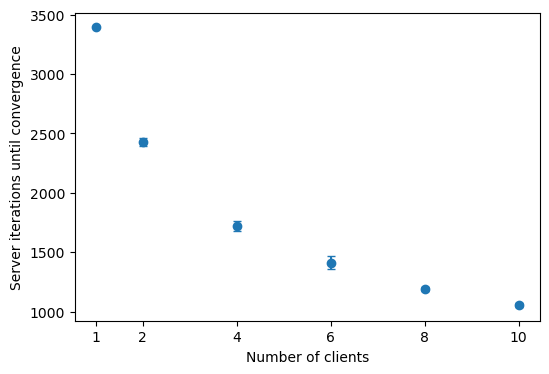

In [16]:
y_coords = results["loss_avg"]
x_coords = results["clients"]

plt.figure(figsize=(6, 4))
plt.errorbar(x_coords, y_coords, yerr=results["loss_std"], marker="o", linestyle="", capsize=3)
plt.ylabel("Server iterations until convergence");
plt.xlabel("Number of clients"); 
plt.xticks(x_coords, x_coords);

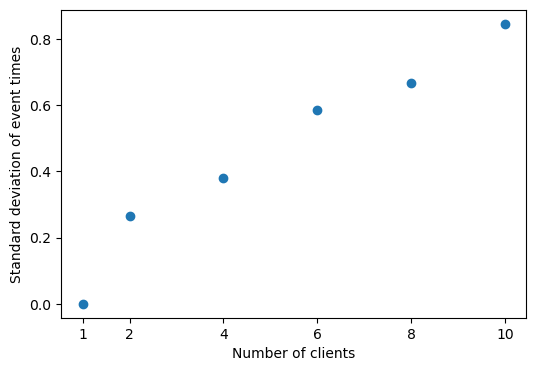

In [17]:
x_coords, y_coords, y_err = [], [], []
for N_SPLITS in [1, 2, 4, 6, 8, 10]:
    
    data_idx = np.arange(data.shape[0])
    np.random.seed(SEEDS[2])
    np.random.shuffle(data_idx)
    DATA_SPLIT_IDX = np.array_split(data_idx, N_SPLITS)

    durations = []
    for idx in range(N_SPLITS):
        data_c = data.iloc[DATA_SPLIT_IDX[idx]]
        durations.append(np.mean(data_c["duration"]))

    x_coords.append(N_SPLITS)
    y_coords.append(np.mean(durations))
    y_err.append(np.std(durations))

# Larger variation in local data distributions as the number of clients increase 
plt.figure(figsize=(6, 4))
#plt.errorbar(x_coords, y_coords, yerr=y_err, marker="o", linestyle="-", capsize=3)
#plt.ylabel("Event time distribution");
plt.plot(x_coords, y_err, marker="o", linestyle="")
plt.ylabel("Standard deviation of event times");
plt.xlabel("Number of clients");
plt.xticks(x_coords, x_coords);

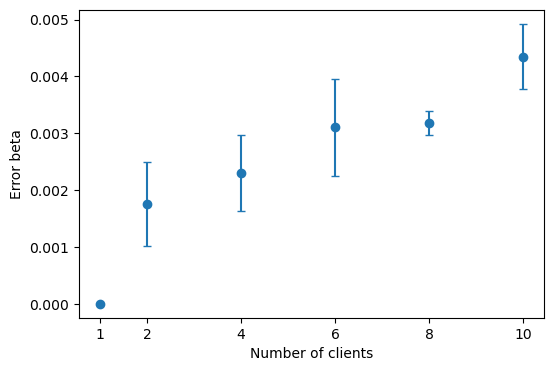

In [18]:
y_coords = results["beta_avg"]
x_coords = results["clients"]

plt.figure(figsize=(6, 4))
plt.errorbar(x_coords, y_coords, yerr=results["beta_std"], marker="o", linestyle="", capsize=3)
plt.ylabel("Error beta");
plt.xlabel("Number of clients");
plt.xticks(x_coords, x_coords);

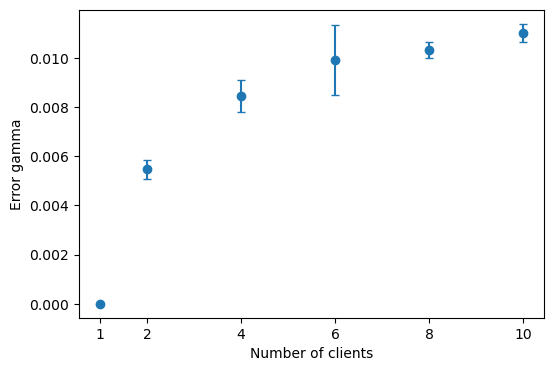

In [19]:
y_coords = results["gamma_avg"]
x_coords = results["clients"]

plt.figure(figsize=(6, 4))
plt.errorbar(x_coords, y_coords, yerr=results["gamma_std"], marker="o", linestyle="", capsize=3)
plt.ylabel("Error gamma");
plt.xlabel("Number of clients");
plt.xticks(x_coords, x_coords);